In [1]:
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('/home/borislav/TrainingPython/datasets/lesson_5_ads_data.csv.zip', compression = 'zip')

## Посмотрим на данные

In [3]:
df.head()

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id
0,23456,1554076848,view,2019-04-01,CPM,0,5681,23456,android,190.0,125560,793
1,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,1041
2,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,41
3,42987,1554135866,view,2019-04-01,CPM,0,28541,42985,ios,199.1,80160,898
4,23456,1554135866,view,2019-04-01,CPM,0,5681,23456,web,190.0,125560,29


In [4]:
df.dtypes

ad_id                      int64
time                       int64
event                     object
date                      object
ad_cost_type              object
has_video                  int64
client_union_id            int64
campaign_union_id          int64
platform                  object
ad_cost                  float64
target_audience_count      int64
user_id                    int64
dtype: object

## Задачи

Представьте, что вы устроились работать аналитиком в отдел рекламы, и ваша первая задача — помочь коллегам разобраться с некоторыми вопросами:

Получить статистику по дням. Посчитать число всех событий по дням, число показов, число кликов, число уникальных объявлений и уникальных кампаний.

Разобраться, почему случился такой скачок 2019-04-05? Каких событий стало больше? У всех объявлений или только у некоторых?

Найти топ 10 объявлений по CTR за все время. CTR — это отношение всех кликов объявлений к просмотрам. Например, если у объявления было 100 показов и 2 клика, CTR = 0.02. Различается ли средний и медианный CTR объявлений в наших данных?

Похоже, в наших логах есть баг, объявления приходят с кликами, но без показов! Сколько таких объявлений, есть ли какие-то закономерности? Эта проблема наблюдается на всех платформах?

Есть ли различия в CTR у объявлений с видео и без? А чему равняется 95 процентиль CTR по всем объявлениям за 2019-04-04?


Для финансового отчета нужно рассчитать наш заработок по дням. В какой день мы заработали больше всего? В какой меньше? Мы списываем с клиентов деньги, если произошел клик по CPC объявлению, и мы списываем деньги за каждый показ CPM объявления, если у CPM объявления цена 200 рублей, то за один показ мы зарабатываем 200 / 1000.

Какая платформа самая популярная для размещения рекламных объявлений? Сколько процентов показов приходится на каждую из платформ (колонка platform)?
А есть ли такие объявления, по которым сначала произошел клик, а только потом показ?


## 1. Статистика по дням

In [5]:
df.groupby('date', as_index = False).agg({'ad_id':'count'}).rename(columns={'ad_id':'all_events'})

,date,all_events
0,2019-04-01,35567
1,2019-04-02,147329
2,2019-04-03,216529
3,2019-04-04,127699
4,2019-04-05,2284883
5,2019-04-06,364707


In [6]:
df.groupby(['date', 'event'], as_index = False).agg({'ad_id':'count'}).pivot(index = 'date', columns = 'event', values = 'ad_id').reset_index()

event,date,click,view
0,2019-04-01,735,34832
1,2019-04-02,1518,145811
2,2019-04-03,1678,214851
3,2019-04-04,1517,126182
4,2019-04-05,501595,1783288
5,2019-04-06,80420,284287


In [7]:
df.groupby('date')['ad_id'].nunique().reset_index()

,date,ad_id
0,2019-04-01,49
1,2019-04-02,146
2,2019-04-03,179
3,2019-04-04,150
4,2019-04-05,131
5,2019-04-06,61


In [8]:
df.groupby('date')['campaign_union_id'].nunique().reset_index()

,date,campaign_union_id
0,2019-04-01,49
1,2019-04-02,146
2,2019-04-03,177
3,2019-04-04,147
4,2019-04-05,130
5,2019-04-06,60


## 2. Разобраться, почему случился такой скачок 2019-04-05? Каких событий стало больше? У всех объявлений или только у некоторых?


In [9]:
df.groupby(['date', 'ad_id'])['event'].agg('count').reset_index().sort_values('event', ascending= False)

,date,ad_id,event
632,2019-04-05,112583,2166611
706,2019-04-06,112583,348613
329,2019-04-03,104798,94554
551,2019-04-05,29927,27186
325,2019-04-03,102587,18893
...,...,...,...
72,2019-04-02,25665,3
169,2019-04-02,113348,3
145,2019-04-02,46363,2
19,2019-04-01,41424,2


#### Мы видим, что объявление с номером 112583 имеет аномально высокое число событий. Именно из-за него произошел скачок роста в тот день, предположительно, крупный рекламодатель запустил рекламную акцию и спровоцировал такое число кликов

## 3. Найти топ 10 объявлений по CTR за все время. 
### CTR — это отношение всех кликов объявлений к просмотрам. Например, если у объявления было 100 показов и 2 клика, CTR = 0.02. Различается ли средний и медианный CTR объявлений в наших данных?

In [10]:
x = pd.DataFrame(df.groupby(['ad_id', 'event'], as_index= False)['date'].agg('count')).rename(columns= {'event':'type_of_event', 'date': 'all_events'})

In [11]:
x = pd.pivot_table(data = x, values = 'all_events', index = 'ad_id', columns= 'type_of_event').reset_index()

In [12]:
x['ctr'] = round((x['click'] / x['view']), 6)

In [13]:
x.sort_values('ctr', ascending= False).head(10)

type_of_event,ad_id,click,view,ctr
289,112583,580436.0,1934788.0,0.300000
324,119450,258.0,1254.0,0.205742
125,38575,43.0,257.0,0.167315
144,40968,29.0,217.0,0.133641
207,45642,42.0,344.0,0.122093
283,110924,11.0,95.0,0.115789
194,45043,28.0,245.0,0.114286
96,35034,112.0,997.0,0.112337
5,4585,53.0,476.0,0.111345
328,120347,236.0,2168.0,0.108856


In [14]:
x.ctr.median()

0.010752999999999999

In [15]:
x.ctr.mean()

0.020628098039215684

/home/borislav/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ctr'>

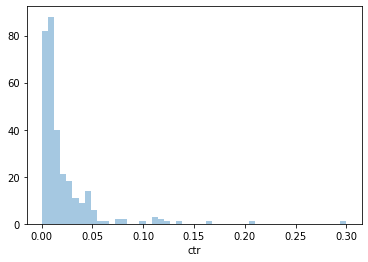

In [16]:
sns.distplot(x.ctr, kde = False)

#### Мы увидели топ 10 объявлений и сравнили медианное и среднее значение ctr. Из распределения видно, почему среднее и медианное значение СУЩЕСТВЕННО различаются. Это связано с аномальными значениями выбросов ctr. Поэтому корректнее сравнивать медианное значене CTR

## 4. Похоже, в наших логах есть баг, объявления приходят с кликами, но без показов! 
Сколько таких объявлений, есть ли какие-то закономерности? Эта проблема наблюдается на всех платформах?


In [17]:
ads_data = x.fillna(0)   #Заменяем пропуски на нули

In [18]:
ads_data = ads_data.query('click == 0')   #Число объявлений с количество кликов = 0

In [19]:
ads_data.merge(df, how = 'inner', on ='ad_id').groupby(['ad_id','platform'])['click'].agg('count').reset_index()  #Объеденим с датафреймом, проблема наблюдается на всех платформах

,ad_id,platform,click
0,2475,android,59
1,2475,ios,55
2,2475,web,18
3,16444,android,79
4,16444,ios,58
...,...,...,...
115,121513,ios,184
116,121513,web,99
117,121695,android,167
118,121695,ios,86


## 5. Есть ли различия в CTR у объявлений с видео и без? А чему равняется 95 процентиль CTR по всем объявлениям за 2019-04-04?


,has_video,ctr
0,0,0.241019
1,1,0.002830


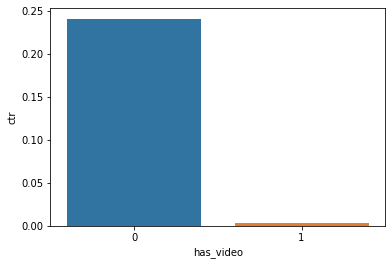

In [20]:
difference = x.merge(df, how = 'inner', on = 'ad_id').groupby('has_video')['ctr'].mean().reset_index()   #Да, различия есть 
sns.barplot(x = 'has_video', y = 'ctr', data = difference)
difference

In [21]:
x.merge(df, how = 'inner', on = 'ad_id').query('date == "2019-04-04"').drop_duplicates().ctr.quantile(0.95)

0.050728

## 6 Отчет
Для финансового отчета нужно рассчитать наш заработок по дням. В какой день мы заработали больше всего? В какой меньше?  
Мы списываем с клиентов деньги, если произошел клик по CPC объявлению, и мы списываем деньги за каждый показ CPM объявления, если у CPM объявления цена 200 рублей, то за один показ мы зарабатываем 200 / 1000.  
Какая платформа самая популярная для размещения рекламных объявлений? Сколько процентов показов приходится на каждую из платформ (колонка platform)?  


In [22]:
df

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id
0,23456,1554076848,view,2019-04-01,CPM,0,5681,23456,android,190.0,125560,793
1,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,1041
2,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,41
3,42987,1554135866,view,2019-04-01,CPM,0,28541,42985,ios,199.1,80160,898
4,23456,1554135866,view,2019-04-01,CPM,0,5681,23456,web,190.0,125560,29
...,...,...,...,...,...,...,...,...,...,...,...,...
3176709,112583,1554501092,view,2019-04-06,CPM,0,111818,112260,android,199.4,239408,5467
3176710,112583,1554501092,view,2019-04-06,CPM,0,111818,112260,android,199.4,239408,2508
3176711,112583,1554501092,click,2019-04-06,CPM,0,111818,112260,web,199.4,239408,7896
3176712,112583,1554501092,view,2019-04-06,CPM,0,111818,112260,ios,199.4,239408,4319


In [23]:
df[(df.ad_cost_type == 'CPC') & (df.event == 'click')].ad_cost.sum()

84810.0

In [24]:
df[(df.ad_cost_type == 'CPM') & (df.event == 'view')].ad_cost.sum() / 1000

497090.6778000003

In [25]:
df.query('event == "view"').groupby(['platform']).event.value_counts()

platform  event
android   view     1295189
ios       view      776114
web       view      517948
Name: event, dtype: int64

In [32]:
new_df = pd.read_csv('/home/borislav/Загрузки/5_data.csv.zip',  encoding='windows-1251')

In [33]:
new_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


Проверьте, встречаются ли в данных повторяющиеся наблюдения, и в качестве ответа укажите их количество. Если они есть, то удалите их из retail.

In [35]:
new_df.duplicated().sum()
new_df.drop_duplicates(inplace=True)

Данные содержат в себе записи как об успешных транзакциях, так и об отмененных. Если пользователь отменил заказ, в начале номера транзакции (InvoiceNo) ставится C (canceled). 

Сколько всего транзакций отменили пользователи? Каждый отдельный тип продукта считайте за отдельную транзакцию - уникальные номера считать не надо.

In [43]:
new_df[new_df.InvoiceNo.str.startswith('C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


Теперь отфильтруйте данные и оставьте в retail только те заказы, где Quantity > 0. В качестве ответа укажите число оставшихся строк.

In [44]:
len(new_df.query('Quantity > 0'))

526054

Посчитайте число заказов для каждого пользователя (CustomerID) из Германии (Germany). Оставьте только тех, кто совершил более N транзакций (InvoiceNo), где N – 80% процентиль. Запишите полученные id пользователей в germany_top (не весь датафрейм, только id).

In [69]:
germany_top = new_df[new_df['Country'] == "Germany"].groupby('CustomerID')['InvoiceNo'].agg('count').reset_index()

In [70]:
germany_top = germany_top[germany_top.InvoiceNo > germany_top['InvoiceNo'].quantile(0.8)].CustomerID
germany_top = pd.DataFrame({'id' : germany_top})

In [71]:
germany_top

,id
3,12471.0
4,12472.0
5,12473.0
6,12474.0
8,12476.0
9,12477.0
12,12481.0
20,12517.0
37,12569.0
53,12621.0


In [74]:
df_transactions = pd.read_csv('/home/borislav/Загрузки/transaction_data.csv')

/home/borislav/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='transaction', ylabel='count'>

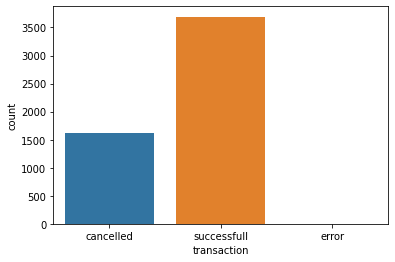

In [80]:
sns.countplot(df_transactions.transaction)

In [82]:
df_transactions.transaction.value_counts()

successfull    3692
cancelled      1619
error             4
Name: transaction, dtype: int64